In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

2025-01-19 20:26:10.777607: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Paths
dataset_csv = "/home/riashad/projects/final-thesis/dataset/csv/final_dataset.csv"

In [3]:
# Parameters
batch_size = 32
image_size = (224, 224)
num_classes = 3
learning_rate = 1e-4
epochs = 30

In [4]:
# Load CSV and split data
df = pd.read_csv(dataset_csv)
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

In [5]:
# Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image_path",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="image_path",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,  # Ensure proper evaluation
)

Found 4730 validated image filenames belonging to 3 classes.
Found 1183 validated image filenames belonging to 3 classes.


In [6]:
# Build the Model
base_model = ResNet50V2(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Regularization
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)  # Add another dropout layer
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [9]:
# Callbacks
checkpoint = ModelCheckpoint(
    "ResNet50V2.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

callbacks = [checkpoint, early_stopping, lr_scheduler]

In [10]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1,
)

/home/riashad/anaconda3/envs/ml/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 424s 3s/step - accuracy: 0.4421 - loss: 1.6049 - val_accuracy: 0.8216 - val_loss: 0.4742 - learning_rate: 1.0000e-04
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 543s 4s/step - accuracy: 0.7062 - loss: 0.7466 - val_accuracy: 0.8470 - val_loss: 0.3851 - learning_rate: 1.0000e-04
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - accuracy: 0.7657 - loss: 0.5857 - val_accuracy: 0.8673 - val_loss: 0.3350 - learning_rate: 1.0000e-04
Epoch 4/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 496s 3s/step - accuracy: 0.7925 - loss: 0.5302 - val_accuracy: 0.8825 - val_loss: 0.3144 - learning_rate: 1.0000e-04
Epoch 5/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 496s 3s/step - accuracy: 0.7982 - loss: 0.5231 - val_accuracy: 0.8952 - val_loss: 0.2925 - learning_rate: 1.0000e-04
Epoch 6/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 499s 3s/step - accuracy: 0.8340 - loss: 0.4342 - val_accuracy: 0.8876 - val_loss: 0.2878 - learning_rate: 1.0000e-04
Epoch 7/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - acc

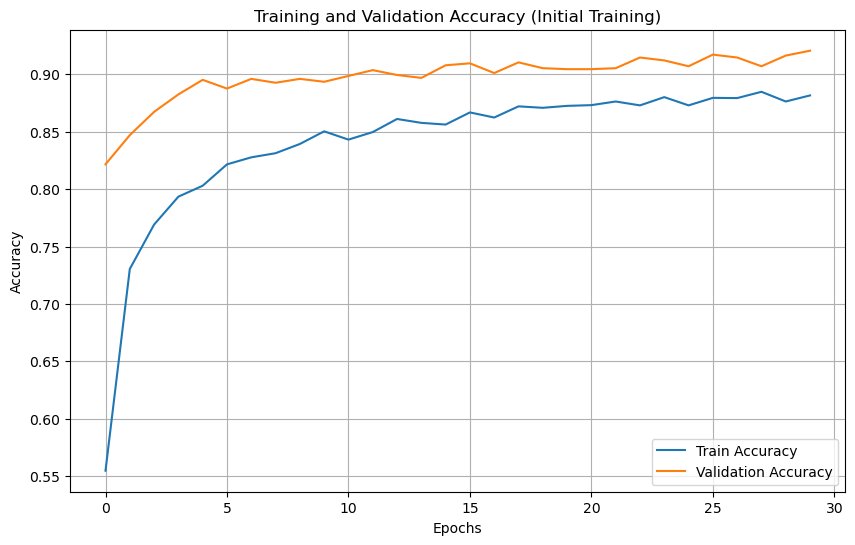

In [11]:
# Visualize Initial Training Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Initial Training)')
plt.legend()
plt.grid()
plt.show()

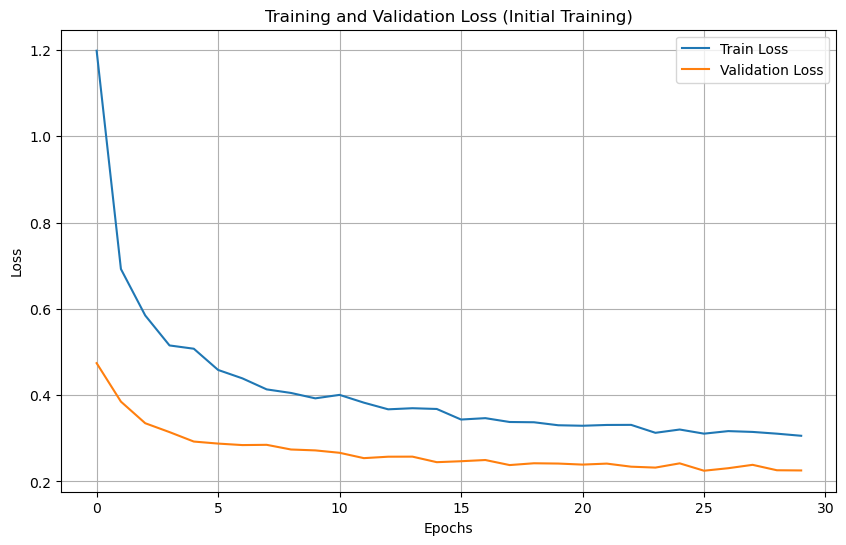

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Initial Training)')
plt.legend()
plt.grid()
plt.show()

In [13]:
# Unfreeze and Fine-tune
for layer in base_model.layers:
    layer.trainable = True

In [14]:
# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [15]:
# Fine-tune
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs // 2,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 1920s 13s/step - accuracy: 0.7342 - loss: 0.6417 - val_accuracy: 0.9036 - val_loss: 0.2574 - learning_rate: 1.0000e-05
Epoch 2/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 1714s 12s/step - accuracy: 0.8699 - loss: 0.3360 - val_accuracy: 0.9205 - val_loss: 0.2210 - learning_rate: 1.0000e-05
Epoch 3/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 1716s 12s/step - accuracy: 0.8959 - loss: 0.2780 - val_accuracy: 0.9231 - val_loss: 0.2068 - learning_rate: 1.0000e-05
Epoch 4/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 1712s 12s/step - accuracy: 0.9094 - loss: 0.2476 - val_accuracy: 0.9256 - val_loss: 0.1988 - learning_rate: 1.0000e-05
Epoch 5/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 1716s 12s/step - accuracy: 0.9232 - loss: 0.2188 - val_accuracy: 0.9332 - val_loss: 0.1863 - learning_rate: 1.0000e-05
Epoch 6/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 1762s 12s/step - accuracy: 0.9263 - loss: 0.1858 - val_accuracy: 0.9298 - val_loss: 0.1857 - learning_rate: 1.0000e-05
Epoch 7/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 1704s 

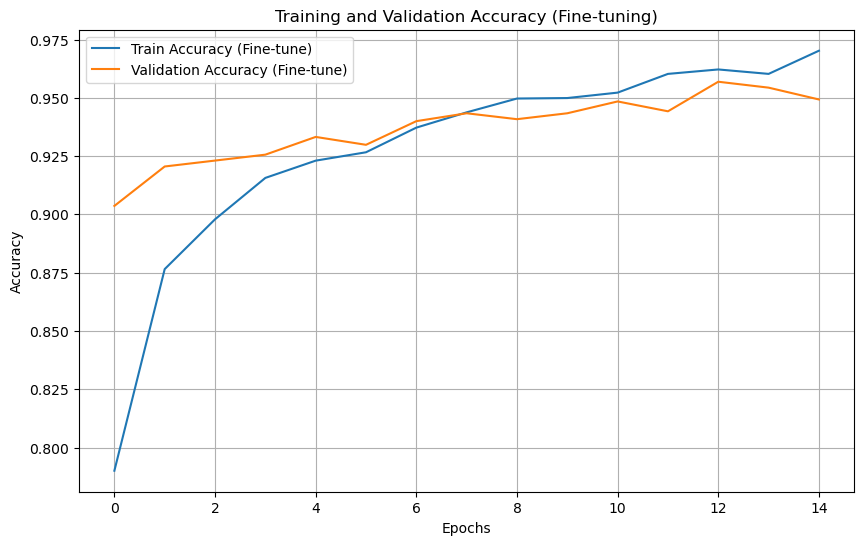

In [16]:
# Visualize Fine-tuning Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy (Fine-tune)')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy (Fine-tune)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Fine-tuning)')
plt.legend()
plt.grid()
plt.show()

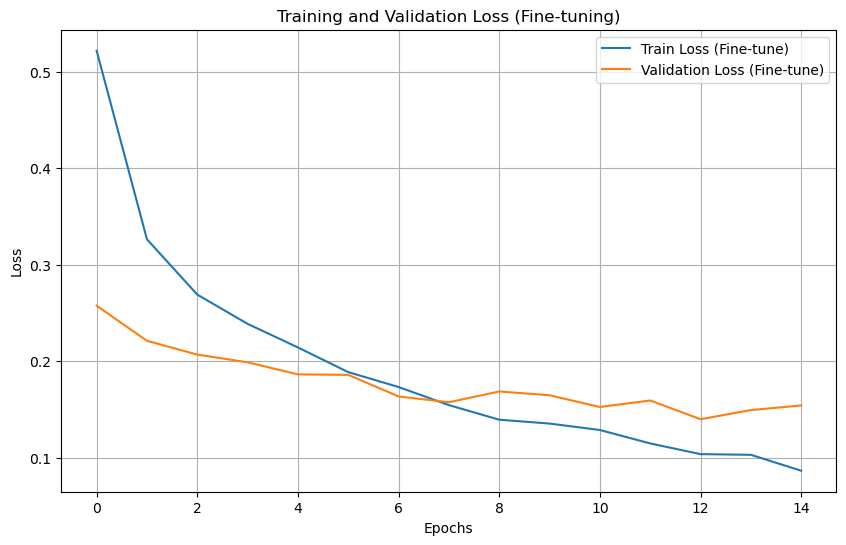

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(fine_tune_history.history['loss'], label='Train Loss (Fine-tune)')
plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss (Fine-tune)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Fine-tuning)')
plt.legend()
plt.grid()
plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step


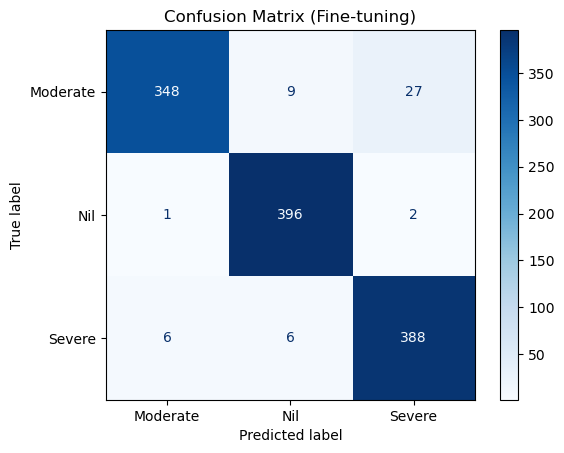

Classification Report (Fine-tuning):
               precision    recall  f1-score   support

    Moderate       0.98      0.91      0.94       384
         Nil       0.96      0.99      0.98       399
      Severe       0.93      0.97      0.95       400

    accuracy                           0.96      1183
   macro avg       0.96      0.96      0.96      1183
weighted avg       0.96      0.96      0.96      1183



In [18]:
# Evaluation: Confusion Matrix and Classification Report
val_predictions = np.argmax(model.predict(val_generator), axis=-1)
val_labels = val_generator.classes  # Correctly retrieve true labels from the generator

cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix (Fine-tuning)')
plt.show()

report = classification_report(val_labels, val_predictions, target_names=val_generator.class_indices.keys())
print("Classification Report (Fine-tuning):\n", report)

In [19]:
# Save the Fine-tuned Model
model.save("ResNet50V2_finetuned.keras")